## Gabriel Dimonde
## Dr. Domec
## ENGR 400G
## 23 April 2023
# Final Project 
# Autoencoder Pretrained - Fully Connected Classifier vs Convolutional Classifier

## Importing Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
import keras.backend as K
import keras
from functools import partial
import os
tf.random.set_seed(42)

%matplotlib inline

2023-04-23 20:39:38.622374: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 20:39:39.434495: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Importing the dataset

In [2]:
microgmeta = pd.read_csv('new_metadata.csv')

In [3]:
microgmeta

,path,anneal_temperature,anneal_time,anneal_time_unit,cool_method,magnification,primary_microconstituent
0,micrograph2.png,800,85,H,Q,1964X,spheroidite
1,micrograph4.png,970,90,M,FC,NaN,pearlite+spheroidite
2,micrograph5.png,750,5,M,Q,4910X,pearlite
3,micrograph6.png,970,90,M,AR,1178X,spheroidite
4,micrograph7.png,970,90,M,Q,982x,spheroidite+widmanstatten
...,...,...,...,...,...,...,...
593,micrograph1720.png,800,24,H,Q,4910X,spheroidite
594,micrograph1722.png,970,24,H,Q,1473X,spheroidite
595,micrograph1726.png,970,5,M,FC,3437X,spheroidite+widmanstatten
596,micrograph1730.png,970,90,M,Q,1964X,spheroidite


It seems that there are only 598 labeled instances of images. Since we are training neural networks an option that we have here is to pre-train 
autoencoders on the unlabeled images. There are a total of 961 micrographs, so unlabeled training should start with the rest. 

In [4]:
microgmeta['primary_microconstituent'].value_counts()

primary_microconstituent
spheroidite                  372
network                      101
spheroidite+widmanstatten     77
pearlite+spheroidite          28
pearlite                      15
pearlite+widmanstatten         5
Name: count, dtype: int64

Which means that the test data must be stratified according to this distribution. The class with the most instances is spheroidite. 

In [5]:
label_count_train=pd.value_counts(microgmeta['primary_microconstituent'], sort=True) 
label_percent_train=label_count_train/microgmeta['primary_microconstituent'].count()*100 #create a percentage based on the catagory counts / the number of entries 
print(label_count_train, sep='\n')
print(label_percent_train, 'percent')

primary_microconstituent
spheroidite                  372
network                      101
spheroidite+widmanstatten     77
pearlite+spheroidite          28
pearlite                      15
pearlite+widmanstatten         5
Name: count, dtype: int64
primary_microconstituent
spheroidite                  62.207358
network                      16.889632
spheroidite+widmanstatten    12.876254
pearlite+spheroidite          4.682274
pearlite                      2.508361
pearlite+widmanstatten        0.836120
Name: count, dtype: float64 percent


This calculates the class percentage of the instances in the Labeled_Test_Dir.

In [6]:
import os
directory_path = "/home/gabriel/Desktop/Final Project/For Training/Labeled_Test_Dir"
folder_list = os.listdir(directory_path)
# print("Here is the folder list: ",folder_list)
num_folder = len(folder_list)
# print("Here is the number of folders in this list: ", num_folder)


num_files = 0 
Test_instance_distribution = {}
total_files = 0


for folder in folder_list: 
    file_path = "/home/gabriel/Desktop/Final Project/For Training/Labeled_Test_Dir/" + folder
    # print("Retrieving from: ",file_path)
    num_files = len(os.listdir(file_path))
    # print("Here are the number of files: ",file_path)
    Test_instance_distribution[folder] = num_files
    total_files += num_files
    # print("Here are the total number of files counted: ",total_files)
# print(total_files)

for folder in Test_instance_distribution:
    print(folder + "   ", Test_instance_distribution[folder])
for folder in Test_instance_distribution:
    instance_percentage = (Test_instance_distribution[folder]/total_files)*100
    print(folder + "   ", instance_percentage)



spheroidite    75
pearlite+spheroidite    6
pearlite    3
spheroidite+widmanstatten    16
network    21
pearlite+widmanstatten    1
spheroidite    61.47540983606557
pearlite+spheroidite    4.918032786885246
pearlite    2.459016393442623
spheroidite+widmanstatten    13.114754098360656
network    17.21311475409836
pearlite+widmanstatten    0.819672131147541


In [7]:
microgmeta.isnull().sum()

path                         0
anneal_temperature           0
anneal_time                  0
anneal_time_unit             0
cool_method                  0
magnification               42
primary_microconstituent     0
dtype: int64

There are 42 missing values for the magnification feature. They will be left since these features are not going to be used. The non-cropped micrographs contain the magnification feature information within the image, which means the missing magnification labels can be extracted from the non-cropped micrographs. 

Typically, one would feed these other features into the dense network at the end of a convnet, or dense net after one-hot encoding or label encoding. This project is meant to compare the performance of a convnet classifier with a fully connected classifier given only images based on what ultra high carbon steel microstructure(s) are present in the image. The only feature here that is needed is the 'primary_microconstituent' feature as it will act as our label.

## Preprocessing

The labeled and unlabeled images were contained in a single directory, and they had names like: Croppedmicrograph#.png. ChatGPT wrote code to delete the "Cropped" portion of the name for each image.

In [8]:
# import os

# # Set the directory containing the files to be renamed
# dir_path = r"C:\Users\Gabriel Dimonde\Desktop\4.ENGR400\Final Project\For Training\Cropped"

# # Set the part of the filename to be removed
# part_to_remove = "Cropped"

# # Iterate over all files in the directory
# for filename in os.listdir(dir_path):
#     # Check if the file contains the part to be removed
#     if part_to_remove in filename:
#         # Construct the new filename by removing the part to be removed
#         new_filename = filename.replace(part_to_remove, "")
#         # Construct the full file paths for the old and new files
#         old_path = os.path.join(dir_path, filename)
#         new_path = os.path.join(dir_path, new_filename)
#         # Rename the file by moving it to the new path
#         os.rename(old_path, new_path)

ChatGPT wrote code to take the images from that directory and sort the according to their labeled or unlabled status. 

In [9]:
# import csv
# import os
# import shutil

# # Set the source directory where the files are located
# source_dir = r"C:\Users\Gabriel Dimonde\Desktop\4.ENGR400\Final Project\For Training\Cropped"

# # Set the destination directory where the files will be moved to
# dest_dir = r"C:\Users\Gabriel Dimonde\Desktop\4.ENGR400\Final Project\For Training\Labeled_Cropped"

# # Set the name of the CSV file and the column name containing the filenames to move
# csv_file = r"C:\Users\Gabriel Dimonde\Desktop\4.ENGR400\Final Project\new_metadata.csv"
# filename_column = r"ï»¿path"
# print(reader.fieldnames)
# # Open the CSV file and read the filenames to move
# with open(csv_file, "r") as f:
#     reader = csv.DictReader(f)
#     filenames_to_move = [row[filename_column] for row in reader]

# # Move each file from the source directory to the destination directory
# for filename in filenames_to_move:
#     source_path = os.path.join(source_dir, filename)
#     dest_path = os.path.join(dest_dir, filename)
#     shutil.move(source_path, dest_path)

ChatGPT wrote code to sort the labeled images by class and place those images in a folder with the class name.

In [10]:
# import os
# import csv
# import shutil

# # Set the directory containing the files to be moved
# src_dir = "/home/gabriel/Desktop/Final Project/For Training/Labeled_Cropped copy"

# # Set the directory where the files will be moved to
# dst_dir = "/home/gabriel/Desktop/Final Project/For Training/Labeled_Dir"

# # Set the path to the CSV file containing the filename and class information
# csv_file = "/home/gabriel/Desktop/Final Project/new_metadata.csv"

# # Set the name of the column containing the filenames
# filename_column = "\ufeffpath"

# # Set the name of the column containing the class names
# class_column = "primary_microconstituent"

# # Create a dictionary to store the destination directory paths for each class name
# class_dirs = {}

# # Iterate over each row in the CSV file and add the destination directory for the corresponding class name to the dictionary
# with open(csv_file, "r") as f:
#     reader = csv.DictReader(f)
#     for row in reader:
#         class_name = row[class_column]
#         class_dir = os.path.join(dst_dir, class_name)
#         class_dirs[class_name] = class_dir
#         # Create the directory if it doesn't exist
#         os.makedirs(class_dir, exist_ok=True)

# # Iterate over each file in the source directory
# for filename in os.listdir(src_dir):
#     # Construct the full file path
#     file_path = os.path.join(src_dir, filename)
#     # Check if the file is a regular file (not a directory)
#     if os.path.isfile(file_path):
#         # Open the CSV file again and find the row containing the filename and class information for this file
#         with open(csv_file, "r") as f:
#             reader = csv.DictReader(f)
#             for row in reader:
#                 if row[filename_column] == filename:
#                     class_name = row[class_column]
#                     class_dir = class_dirs[class_name]
#                     # Construct the destination file path
#                     dst_path = os.path.join(class_dir, filename)
#                     # Move the file to the destination directory
#                     shutil.move(file_path, dst_path)

ChatGPT wrote a code to separate 20% of the images in the previously separated class name directories and placed those images into a directory exactly like the original. This is for separating out test instances from the training instances.

ChatGpt was used here because image placement within a file directory is important for the datagen.flow_from_directory() method with "classes" not specifed so that it would infer classes from the directory name. For this method the labels are the folder names and the instances are contained within their respective folders. This route was needed in general for the flow_from_directory() method, if there was no inferring, the class directory locations would need to be specified. 

In [11]:
# import os
# import shutil
# import random
# import math

# # Set the source directory containing the sub-directories with images
# src_dir = "/home/gabriel/Desktop/Final Project/For Training/Labeled_Dir"

# # Set the destination directory for the sampled images
# dst_dir = "/home/gabriel/Desktop/Final Project/For Training/Labeled_Test_Dir"

# # Get a list of all sub-directories in the source directory
# sub_dirs = [os.path.join(src_dir, name) for name in os.listdir(src_dir) if os.path.isdir(os.path.join(src_dir, name))]

# # Create the destination directory if it doesn't exist
# os.makedirs(dst_dir, exist_ok=True)

# # Set the fraction of images to be sampled
# sample_fraction = 0.2

# # Create a dictionary to store the filenames for each class
# class_files = {}

# # Iterate over each sub-directory
# for sub_dir in sub_dirs:
#     # Get the class name from the sub-directory name
#     class_name = os.path.basename(sub_dir)
#     # Get a list of all image files in the sub-directory
#     image_files = [os.path.join(sub_dir, name) for name in os.listdir(sub_dir) if os.path.isfile(os.path.join(sub_dir, name))]
#     # Add the filenames to the dictionary for the class
#     class_files[class_name] = image_files

# # Calculate the number of images to sample for each class
# sample_sizes = {}
# total_sample_size = 0
# for class_name, image_files in class_files.items():
#     class_size = len(image_files)
#     sample_size = math.ceil(class_size * sample_fraction)
#     sample_sizes[class_name] = sample_size
#     total_sample_size += sample_size

# # Create a dictionary to store the sampled filenames for each class
# sampled_files = {}

# # Sample the filenames for each class
# for class_name, image_files in class_files.items():
#     sample_size = sample_sizes[class_name]
#     sampled_files[class_name] = random.sample(image_files, sample_size)

# # Move the sampled files to the destination directory
# for class_name, sampled_image_files in sampled_files.items():
#     class_dir = os.path.join(dst_dir, class_name)
#     os.makedirs(class_dir, exist_ok=True)
#     for sampled_image_file in sampled_image_files:
#         dst_path = os.path.join(class_dir, os.path.basename(sampled_image_file))
#         shutil.copy(sampled_image_file, dst_path)
#         os.remove(sampled_image_file)  # Delete the source file after copying

ChatGPT wrote a code to move 10% of the unlabeled images into another directory for unlabeled validation. No need to stratify.

In [12]:
# import os
# import random
# import shutil

# # Specify the source and destination directories
# source_dir = '/home/gabriel/Desktop/Final Project/For Training/Unlabeled'
# dest_dir = '/home/gabriel/Desktop/Final Project/For Training/UnlabeledValid'

# # Set the percentage of files to move (in this case, 10%)
# percent_to_move = 0.1

# # Get a list of all PNG files in the source directory
# png_files = [f for f in os.listdir(source_dir) if f.endswith('.png')]

# # Calculate the number of files to move
# num_to_move = int(len(png_files) * percent_to_move)

# # Randomly select which files to move
# files_to_move = random.sample(png_files, num_to_move)

# # Move the files to the destination directory
# for f in files_to_move:
#     shutil.move(os.path.join(source_dir, f), os.path.join(dest_dir, f))

### Pulling Unlabeled images into arrays

In [13]:
unlabeled_directory = "/home/gabriel/Desktop/Final Project/For Training/Unlabeled"
unlabeledvalid_directory = "/home/gabriel/Desktop/Final Project/For Training/UnlabeledValid"
pathraw = microgmeta['path']

In [14]:
pathraw

0         micrograph2.png
1         micrograph4.png
2         micrograph5.png
3         micrograph6.png
4         micrograph7.png
              ...        
593    micrograph1720.png
594    micrograph1722.png
595    micrograph1726.png
596    micrograph1730.png
597    micrograph1732.png
Name: path, Length: 598, dtype: object

We do not need to pull the labeled images into memory because we already have them sorted in the directories Labeled_Dir and Labeledtest_Dir. We do need to pull the unlabeled images into arrays (memory) because of the uncertainties present in the autoencoder training as well as the fact that a datagen.flow iterator cannot be fed as a y vector in the model.fit() method. 

In [15]:
unl_micrographs = np.empty((0,256,256,1),dtype = 'float32')
print(unl_micrographs.shape)
for filename in os.listdir(unlabeled_directory):
    pathvar = unlabeled_directory + "/" + filename 
    image = tf.keras.preprocessing.image.load_img(pathvar, color_mode="grayscale", target_size=(256,256))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = input_arr/255.0 # Rescale
    input_arr = np.array([input_arr])# Convert single image to a batch.
    unl_micrographs = np.concatenate((unl_micrographs, input_arr), axis=0)
print(unl_micrographs.shape)

unl_micrographs_valid = np.empty((0,256,256,1),dtype = 'float32')
print(unl_micrographs_valid.shape)
for filename in os.listdir(unlabeledvalid_directory):
    pathvar = unlabeledvalid_directory + "/" + filename 
    image = tf.keras.preprocessing.image.load_img(pathvar, color_mode="grayscale", target_size=(256,256))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = input_arr/255.0 # Rescale
    input_arr = np.array([input_arr])# Convert single image to a batch.
    unl_micrographs_valid = np.concatenate((unl_micrographs_valid, input_arr), axis=0)
print(unl_micrographs_valid.shape)

(0, 256, 256, 1)
(295, 256, 256, 1)
(0, 256, 256, 1)
(68, 256, 256, 1)


## Data Augmentation

Because we may be retraining our model (due to small changes, mistakes), we need to delete all of the augmented images that exist in the augmented directory to prevent the directory from becoming too large. This is needed at the moment because the flow() methods below are set to store images in the below directories. 

In [16]:
labeled_directory = "/home/gabriel/Desktop/Final Project/For Training/Labeled_Dir"
labeledtest_directory = "/home/gabriel/Desktop/Final Project/For Training/Labeled_Test_Dir"
AugTest_directory = "/home/gabriel/Desktop/Final Project/For Training/Augmented/Test"
AugTrain_directory = "/home/gabriel/Desktop/Final Project/For Training/Augmented/Training"
AugPretrain_directory = "/home/gabriel/Desktop/Final Project/For Training/Augmented/Pretraining"
AugValid_directory = "/home/gabriel/Desktop/Final Project/For Training/Augmented/Valid"

This code goes through the above directories and deletes any images saved from a previous training cycle. Made by ChatGPT.

In [17]:
import os

delete_list = [AugTest_directory,AugTrain_directory,AugPretrain_directory,AugValid_directory]
for dir_path in delete_list:
# Iterate over all files in the directory
  for filename in os.listdir(dir_path):
      # Construct the full file path
      file_path = os.path.join(dir_path, filename)
      # Check if the file is a regular file (not a directory)
      if os.path.isfile(file_path):
          # Delete the file
          os.remove(file_path)

This code specifies augmentation parameters, and iterative methods for generating augmented images for training our final models. 

    If preprocessing layers are used to implement augmentation for the unlabeled training set, it is unknown how the error calculations are performed.
    * Model is fed non-augmented images,
    * Preprocessing augments the images, 
    * Decoder attempts to reconstruct the *augmented image*,
    * (uncertainty) - The error is calculated between the reconstructed augmented image and the non-augmented image.
If this last step is True, then whether it is beneficial for model performance has yet to be assessed. 

In [45]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rotation_range=5,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   brightness_range= [0.1,2],
                                   channel_shift_range=0.5,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   rescale = 1./255,
                                   fill_mode='reflect',
                                   validation_split = 0.2)
labeled_training_set = train_datagen.flow_from_directory(labeled_directory,
                                                        target_size=(256,256),
                                                        color_mode = 'grayscale',
                                                        class_mode = "categorical",
                                                        shuffle = True,
                                                        batch_size = 5,
                                                        seed = 42,
                                                        save_to_dir=AugTrain_directory,
                                                        save_prefix='train',
                                                        save_format='png',
                                                        subset = 'training',
                                                        keep_aspect_ratio = True)
labeled_valid_set = train_datagen.flow_from_directory(labeled_directory,
                                                        target_size=(256,256),
                                                        color_mode = 'grayscale',
                                                        class_mode = "categorical",
                                                        shuffle = True,
                                                        batch_size = 5,
                                                        seed = 42,
                                                        save_to_dir=AugValid_directory,
                                                        save_prefix='valid',
                                                        save_format='png',
                                                        subset = 'validation',
                                                        keep_aspect_ratio = True)
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(labeledtest_directory,
                                            target_size=(256,256),
                                            color_mode = 'grayscale',
                                            class_mode = "categorical",
                                            batch_size = 1,
                                            seed = 42,
                                            save_to_dir=AugTest_directory,
                                            save_prefix='test',
                                            save_format='png',
                                            keep_aspect_ratio = True)

Found 383 images belonging to 6 classes.
Found 93 images belonging to 6 classes.
Found 122 images belonging to 6 classes.


## Fully Connected Network

#### Fully Connected Autoencoder

Note that there is not going to be preprocessing here due to the above uncertainty. 

In [87]:
K.clear_session()
Dense_Tied_AE = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[256, 256,1]),
    tf.keras.layers.Dense(2000, activation="relu"),
    tf.keras.layers.Dense(1000, activation="relu"),
    tf.keras.layers.Dense(750, activation="relu"),
    tf.keras.layers.Dense(1000, activation="relu"),
    tf.keras.layers.Dense(2000, activation="relu"),
    tf.keras.layers.Dense(256*256),
    tf.keras.layers.Reshape([256,256,1])
])

In [96]:
Dense_Tied_AE.build([None,256,256,1])
Dense_Tied_AE.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 2000)              131074000 
                                                                 
 dense_1 (Dense)             (None, 1000)              2001000   
                                                                 
 dense_2 (Dense)             (None, 750)               750750    
                                                                 
 dense_3 (Dense)             (None, 1000)              751000    
                                                                 
 dense_4 (Dense)             (None, 2000)              2002000   
                                                                 
 dense_5 (Dense)             (None, 65536)             1

In [91]:
Dense_Tied_AE.compile(loss='mse',optimizer='nadam');
denseae_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints",
                                                   monitor='val_loss',
                                                   save_best_only=True)
denseae_early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     monitor='val_loss',
                                                     restore_best_weights=True)
from datetime import datetime
logs = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
denseae_tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=logs,
                                                histogram_freq=1,
                                                profile_batch=(100, 200))

2023-04-23 17:13:26.836955: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-04-23 17:13:26.837000: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2023-04-23 17:13:26.845006: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2023-04-23 17:13:26.845325: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1813] CUPTI activity buffer flushed


In [ ]:
denseae_history = Dense_Tied_AE.fit(unl_micrographs,
                                          unl_micrographs,
                                          batch_size=10,
                                          epochs=100,
                                          validation_data=(unl_micrographs_valid,unl_micrographs_valid),
                                          callbacks=[denseae_checkpoint_cb, denseae_early_stopping_cb,denseae_tensorboard_cb])

This model got as low as 0.0648 for the mean square error validation loss. 

#### Saving the Fully Connected Autoencoder.

In [ ]:
Dense_Tied_AE.save("Dense_Tied_AE", save_format="tf")

#### Plotting image Reconstructions

This code takes the above model, predicts on some images that it has seen and plots the input and output images. This code is from the book's Chapter 17 example jupyter notebook.

1/1 [==============================] - 0s 122ms/step


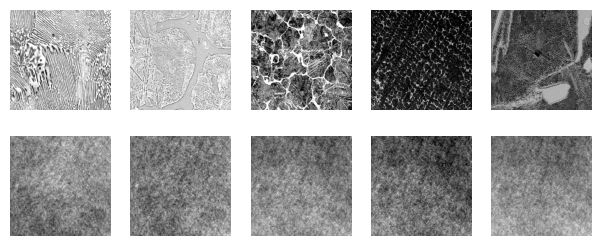

In [95]:
def plot_reconstructions(model, images = unl_micrographs_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]),0,1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index],cmap='binary')
        plt.axis('off')
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index],cmap='binary')
        plt.axis('off')
    
plot_reconstructions(Dense_Tied_AE)
plt.show()

The reconstructed images do not look at all like the input images. But I do notice that the model's output looks the same, i.e., it has been able to learn a very simple pattern. Maybe it is necessary to use more neurons, then more layers. I may be bottlenecking the information too much. 

#### Transfer Learning

In [118]:
Dense_Tied_AE = keras.models.load_model("Dense_Tied_AE")

In [119]:
Dense_Tied_AE_clone = tf.keras.models.clone_model(Dense_Tied_AE)
Dense_Tied_AE_clone.set_weights(Dense_Tied_AE.get_weights())

In [ ]:
Dense_Tied_AE.layers

In [121]:
Dense_Class = tf.keras.Sequential([
    Dense_Tied_AE_clone.layers[0],
    Dense_Tied_AE_clone.layers[1],
    Dense_Tied_AE_clone.layers[2],
    Dense_Tied_AE_clone.layers[3],
    tf.keras.layers.Dense(200, activation="relu"), # attempting to keep the dense network the same accross classifier models
    tf.keras.layers.Dense(200, activation="relu"),
    tf.keras.layers.Dense(200, activation="relu"),
    tf.keras.layers.Dense(200, activation="relu"),
    tf.keras.layers.Dense(6, activation="softmax")])# There are 6 classes.

In [122]:
for layer in Dense_Class.layers[:-5]:
    layer.trainable = False

Here we specify a low learning rate meant to warm up the upper layers.

In [123]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001)
Dense_Class.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=["accuracy"])

In [124]:
Dense_Class.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 2000)              131074000 
                                                                 
 dense_1 (Dense)             (None, 1000)              2001000   
                                                                 
 dense_2 (Dense)             (None, 750)               750750    
                                                                 
 dense_10 (Dense)            (None, 200)               150200    
                                                                 
 dense_11 (Dense)            (None, 200)               40200     
                                                                 
 dense_12 (Dense)            (None, 200)              

In [ ]:
tf.keras.utils.plot_model(Dense_Class, 'Dense_Tied_AE.png', show_shapes=True)

##### Training Upper layers 

In [126]:
denseclass_history = Dense_Class.fit(labeled_training_set,epochs=4,validation_data=labeled_valid_set) 

Epoch 1/4


2023-04-23 18:58:52.400383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


77/77 [==============================] - ETA: 0s - loss: 1.3084 - accuracy: 0.5796

2023-04-23 18:59:02.589620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


77/77 [==============================] - 13s 158ms/step - loss: 1.3084 - accuracy: 0.5796 - val_loss: 1.2025 - val_accuracy: 0.6344
Epoch 2/4
77/77 [==============================] - 11s 149ms/step - loss: 1.3102 - accuracy: 0.6240 - val_loss: 1.2235 - val_accuracy: 0.6344
Epoch 3/4
77/77 [==============================] - 12s 152ms/step - loss: 1.2406 - accuracy: 0.6188 - val_loss: 1.2715 - val_accuracy: 0.6452
Epoch 4/4
77/77 [==============================] - 12s 151ms/step - loss: 1.2613 - accuracy: 0.6214 - val_loss: 1.2140 - val_accuracy: 0.6344


##### Training Lower Layers

In [127]:
# unfreezing layers
for layer in Dense_Class.layers[:-5]:
    layer.trainable = True
# refreezing extreme lower layers
for layer in Dense_Class.layers[:-6]:
    layer.trainable = False

In [128]:
Dense_Class.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 2000)              131074000 
                                                                 
 dense_1 (Dense)             (None, 1000)              2001000   
                                                                 
 dense_2 (Dense)             (None, 750)               750750    
                                                                 
 dense_10 (Dense)            (None, 200)               150200    
                                                                 
 dense_11 (Dense)            (None, 200)               40200     
                                                                 
 dense_12 (Dense)            (None, 200)              

In [129]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001)
Dense_Class.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=["accuracy"])
dense_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints",
                                                   monitor='val_loss',
                                                   save_best_only=True)
dense_early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     monitor='val_loss',
                                                     restore_best_weights=True)
from datetime import datetime
logs = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
dense_tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=logs,
                                                histogram_freq=1,
                                                profile_batch=(100, 200))

2023-04-23 19:03:49.972341: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-04-23 19:03:49.972390: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2023-04-23 19:03:49.991199: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2023-04-23 19:03:49.991451: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1813] CUPTI activity buffer flushed


In [131]:
denseclass_history = Dense_Class.fit(labeled_training_set,
                                epochs = 16,
                                validation_data=labeled_valid_set,
                                callbacks=[denseae_checkpoint_cb, denseae_early_stopping_cb, denseae_tensorboard_cb]) 

Epoch 1/16


2023-04-23 19:03:59.615261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


77/77 [==============================] - ETA: 0s - loss: 1.3112 - accuracy: 0.6240

2023-04-23 19:04:09.898439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


77/77 [==============================] - 23s 293ms/step - loss: 1.3112 - accuracy: 0.6240 - val_loss: 1.1562 - val_accuracy: 0.6344
Epoch 2/16
23/77 [=======>......................] - ETA: 7s - loss: 1.3365 - accuracy: 0.5575

2023-04-23 19:04:25.580050: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-04-23 19:04:25.580111: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.


77/77 [==============================] - 22s 284ms/step - loss: 1.2763 - accuracy: 0.6240 - val_loss: 1.2390 - val_accuracy: 0.6344
Epoch 3/16
47/77 [=================>............] - ETA: 3s - loss: 1.3278 - accuracy: 0.5872

2023-04-23 19:04:50.249471: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2023-04-23 19:04:50.252460: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1813] CUPTI activity buffer flushed
2023-04-23 19:04:50.299708: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_collector.cc:541]  GpuTracer has collected 0 callback api events and 0 activity events. 
2023-04-23 19:04:50.302464: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


77/77 [==============================] - 60s 783ms/step - loss: 1.2495 - accuracy: 0.6188 - val_loss: 1.2768 - val_accuracy: 0.6344
Epoch 4/16
77/77 [==============================] - 22s 281ms/step - loss: 1.2641 - accuracy: 0.6240 - val_loss: 1.1750 - val_accuracy: 0.6452
Epoch 5/16
77/77 [==============================] - 22s 283ms/step - loss: 1.2560 - accuracy: 0.6292 - val_loss: 1.2019 - val_accuracy: 0.6452
Epoch 6/16
77/77 [==============================] - 52s 678ms/step - loss: 1.2442 - accuracy: 0.6188 - val_loss: 1.2134 - val_accuracy: 0.6344


In [132]:
# Unfreezing, layers
for layer in Dense_Class.layers[:-6]:
    layer.trainable = True

In [133]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001)
Dense_Class.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=["accuracy"])
dense_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints",
                                                   monitor='val_loss',
                                                   save_best_only=True)
dense_early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     monitor='val_loss',
                                                     restore_best_weights=True)
from datetime import datetime
logs = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
dense_tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=logs,
                                                histogram_freq=1,
                                                profile_batch=(100, 200))

2023-04-23 19:12:42.182176: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-04-23 19:12:42.182226: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2023-04-23 19:12:42.200841: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2023-04-23 19:12:42.201155: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1813] CUPTI activity buffer flushed


In [134]:
denseclass_history = Dense_Class.fit(labeled_training_set,
                                epochs = 16,
                                validation_data=labeled_valid_set,
                                callbacks=[denseae_checkpoint_cb, denseae_early_stopping_cb, denseae_tensorboard_cb]) 

Epoch 1/16


2023-04-23 19:13:20.989743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


77/77 [==============================] - ETA: 0s - loss: 1.3164 - accuracy: 0.5979

2023-04-23 19:13:38.852762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


77/77 [==============================] - 30s 380ms/step - loss: 1.3164 - accuracy: 0.5979 - val_loss: 1.1390 - val_accuracy: 0.6344
Epoch 2/16
22/77 [=======>......................] - ETA: 11s - loss: 1.3174 - accuracy: 0.5833

2023-04-23 19:13:56.144355: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-04-23 19:13:56.144415: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.


77/77 [==============================] - 29s 376ms/step - loss: 1.3005 - accuracy: 0.6240 - val_loss: 1.2469 - val_accuracy: 0.6452
Epoch 3/16
46/77 [================>.............] - ETA: 6s - loss: 1.2751 - accuracy: 0.5921

2023-04-23 19:14:30.077745: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2023-04-23 19:14:30.080149: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1813] CUPTI activity buffer flushed
2023-04-23 19:14:30.131852: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_collector.cc:541]  GpuTracer has collected 0 callback api events and 0 activity events. 
2023-04-23 19:14:30.134643: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


77/77 [==============================] - 28s 362ms/step - loss: 1.2565 - accuracy: 0.6136 - val_loss: 1.1709 - val_accuracy: 0.6452
Epoch 4/16
77/77 [==============================] - 28s 363ms/step - loss: 1.2636 - accuracy: 0.6188 - val_loss: 1.1494 - val_accuracy: 0.6344
Epoch 5/16
77/77 [==============================] - 28s 360ms/step - loss: 1.2527 - accuracy: 0.6292 - val_loss: 1.1039 - val_accuracy: 0.6452
Epoch 6/16
77/77 [==============================] - 27s 344ms/step - loss: 1.2398 - accuracy: 0.6266 - val_loss: 1.1926 - val_accuracy: 0.6452
Epoch 7/16
77/77 [==============================] - 27s 350ms/step - loss: 1.2754 - accuracy: 0.6292 - val_loss: 1.1376 - val_accuracy: 0.6452
Epoch 8/16
77/77 [==============================] - 28s 359ms/step - loss: 1.2741 - accuracy: 0.6292 - val_loss: 1.1248 - val_accuracy: 0.6452
Epoch 9/16
77/77 [==============================] - 28s 360ms/step - loss: 1.2439 - accuracy: 0.6345 - val_loss: 1.1210 - val_accuracy: 0.6559
Epoch 10/1

#### Saving the Fully Connected Classifier

In [ ]:
Dense_Class.save("Dense_Class", save_format="tf")

#### Fully Connected Network Model Evaluation

In [136]:
Dense_Class.evaluate(test_set)

  1/122 [..............................] - ETA: 18s - loss: 1.9584 - accuracy: 0.0000e+00

2023-04-23 19:18:53.845433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


122/122 [==============================] - 8s 67ms/step - loss: 1.1548 - accuracy: 0.6230


[1.154788851737976, 0.6229507923126221]

The below code predicts all of the instances in the test set, and prints out all predictions.

In [141]:
y_pred_dense = Dense_Class.predict(test_set)
y_pred_dense = y_pred_dense.argmax(axis=-1)
print(y_pred_dense)
print(y_pred_dense.shape)

2023-04-23 19:20:26.655759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


122/122 [==============================] - 8s 66ms/step
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4]
(122,)


The below code is meant to retrieve all of the labels from the test_set object.

In [140]:
y_test_dense = np.zeros(1)
for i in np.arange(122):
    dummy = test_set[i][1]
    dummy = dummy.argmax(axis=-1)
    y_test_dense = np.concatenate((y_test_dense, dummy), axis=0)
y_test_dense = np.delete(y_test_dense, 0, axis=0)
print(y_test_dense)
print(y_test_dense.shape)

[0. 4. 4. 4. 0. 4. 4. 5. 4. 4. 4. 5. 0. 4. 5. 0. 4. 4. 5. 0. 2. 4. 4. 4.
 2. 4. 4. 4. 4. 4. 0. 0. 4. 1. 5. 4. 4. 3. 4. 4. 0. 4. 2. 4. 2. 5. 5. 0.
 4. 4. 4. 4. 4. 0. 4. 4. 4. 0. 4. 4. 4. 4. 2. 0. 4. 5. 0. 0. 4. 0. 0. 4.
 4. 0. 4. 4. 4. 4. 4. 4. 4. 5. 4. 5. 4. 4. 4. 4. 4. 4. 5. 4. 4. 4. 5. 4.
 4. 4. 4. 2. 5. 0. 4. 1. 0. 1. 4. 4. 4. 5. 4. 4. 4. 5. 0. 4. 4. 5. 0. 4.
 4. 4.]
(122,)


This code takes the above predictions and ground truth labels and compares the model's performance. 

Test Set Performance 

              precision    recall  f1-score   support

         0.0       1.00      0.05      0.09        21
         1.0       0.00      0.00      0.00         3
         2.0       0.00      0.00      0.00         6
         3.0       0.00      0.00      0.00         1
         4.0       0.62      1.00      0.77        75
         5.0       0.00      0.00      0.00        16

    accuracy                           0.62       122
   macro avg       0.27      0.17      0.14       122
weighted avg       0.55      0.62      0.49       122

[[ 1  0  0  0 20  0]
 [ 0  0  0  0  3  0]
 [ 0  0  0  0  6  0]
 [ 0  0  0  0  1  0]
 [ 0  0  0  0 75  0]
 [ 0  0  0  0 16  0]] 



/home/gabriel/anaconda3/envs/Engr400/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabriel/anaconda3/envs/Engr400/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabriel/anaconda3/envs/Engr400/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

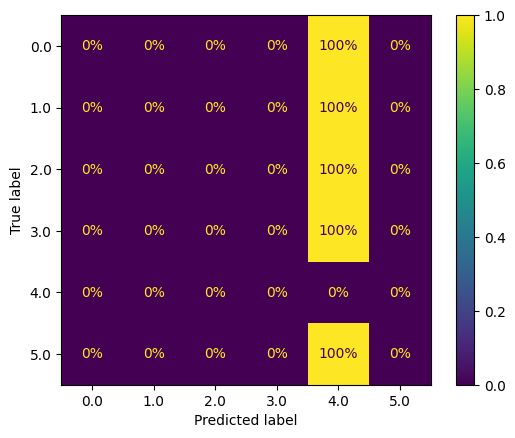

In [142]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
print('Test Set Performance', '\n')
print(classification_report(y_test_dense, y_pred_dense))
print(confusion_matrix(y_test_dense, y_pred_dense), '\n')
sample_weight = (y_pred_dense != y_test_dense)
ConfusionMatrixDisplay.from_predictions(y_test_dense, y_pred_dense,
                                        sample_weight = sample_weight,
                                        normalize = 'true',
                                        values_format = '.0%')

Okay the model always guesses 4...

This seems to mean that the model is too simple, maybe if there were more layers this model would be capable of capturing the more complex patterns function better. 

## Convolutional Network

#### Convolutional Autoencoder

In [22]:
K.clear_session()
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding = 'same',
                        activation='relu', kernel_initializer='he_normal',data_format='channels_last')
DefaultConv2DTranspose = partial(tf.keras.layers.Conv2DTranspose,kernel_size=3,
                                 kernel_initializer='he_normal',data_format='channels_last')

Conv_AE = tf.keras.Sequential([
    tf.keras.layers.Reshape([256,256,1]),
    DefaultConv2D(filters=64,kernel_size=11),
    tf.keras.layers.MaxPool2D(pool_size=2), # output: 128 x 128 x 64
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(pool_size=2), # output: 64 x 64 x 128
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(pool_size=2), # output: 32 x 32 x 256
    DefaultConv2D(filters=512),
    DefaultConv2D(filters=512),
    tf.keras.layers.MaxPool2D(pool_size=2), # output: 16 x 16 x 512
    tf.keras.layers.GlobalAvgPool2D(), # output: 516
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16*16*16),
    tf.keras.layers.Reshape([16,16,16]),
    DefaultConv2DTranspose(filters=256,strides=(2, 2),padding = 'same',activation='relu'), # output: 32 x 32 x 256
    DefaultConv2DTranspose(filters=128,strides=(2, 2),padding = 'same',activation='relu'), # output: 64 x 64 x 128
    DefaultConv2DTranspose(filters=64,strides=(2, 2),padding = 'same',activation='relu'), # output: 128 x 128 x 64
    DefaultConv2DTranspose(filters=1,strides=(2, 2),padding = 'same'), # output: 256 x 256 x 32
    tf.keras.layers.Reshape([256,256,1])
])

In [23]:
Conv_AE.build([None,256,256,1])
Conv_AE.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 256, 256, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      7808      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 256)       2

In [ ]:
Conv_AE.compile(loss='mse',optimizer='nadam');
convae_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints",
                                                   monitor='val_loss',
                                                   save_best_only=True)
convae_early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     monitor='val_loss',
                                                     restore_best_weights=True)
from datetime import datetime
logs = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
convae_tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=logs,
                                                histogram_freq=1,
                                                profile_batch=(100, 200))

In [ ]:
convae_history = Conv_AE.fit(unl_micrographs,unl_micrographs,
                              batch_size=10,
                              epochs=100,
                              validation_data=(unl_micrographs_valid,unl_micrographs_valid),
                              callbacks=[convae_checkpoint_cb, convae_early_stopping_cb, convae_tensorboard_cb])

This code cell output is very long.
The lowest loss is 0.0636.
The lowest validation loss is 0.0639.

#### Saving the Convolutional Autoencoder

In [ ]:
Conv_AE.save("Conv_AE", save_format="tf")

#### Plotting Image Reconstructions

1/1 [==============================] - 0s 381ms/step


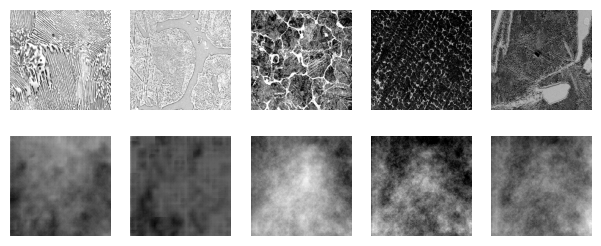

In [28]:
def plot_reconstructions(model, images = unl_micrographs_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]),0,1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index],cmap='binary')
        plt.axis('off')
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index],cmap='binary')
        plt.axis('off')
    
plot_reconstructions(Conv_AE)
plt.show()

OKAY, this model also does not do such a great job at reproducing images.

#### Transfer Learning

In [29]:
Conv_AE_clone = tf.keras.models.clone_model(Conv_AE)
Conv_AE_clone.set_weights(Conv_AE.get_weights())

In [30]:
Conv_Class = tf.keras.Sequential([
    Conv_AE_clone.layers[0],
    Conv_AE_clone.layers[1],
    Conv_AE_clone.layers[2],
    Conv_AE_clone.layers[3],
    Conv_AE_clone.layers[4],
    Conv_AE_clone.layers[5],
    Conv_AE_clone.layers[6],
    Conv_AE_clone.layers[7],
    Conv_AE_clone.layers[8],
    Conv_AE_clone.layers[9],
    Conv_AE_clone.layers[10],
    Conv_AE_clone.layers[11],
    Conv_AE_clone.layers[12],
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(200, activation="relu"),
    tf.keras.layers.Dense(200, activation="relu"),
    tf.keras.layers.Dense(200, activation="relu"),
    tf.keras.layers.Dense(200, activation="relu"),
    tf.keras.layers.Dense(6, activation="softmax") # There are 6 classes.
])

In [31]:
Conv_Class.build([None,256,256,1])

In [ ]:
Conv_Class.layers

In [33]:
for layer in Conv_Class.layers[:-5]:
    layer.trainable = False

Here we specify a low learning rate meant to warm up the five upper layers.

In [34]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001)
Conv_Class.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=["accuracy"])

##### Training Upper layers 

In [36]:
denseclass_history = Conv_Class.fit(labeled_training_set,epochs = 4,validation_data=labeled_valid_set) 

Epoch 1/4


2023-04-23 21:32:08.386092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


77/77 [==============================] - ETA: 0s - loss: 1.7405 - accuracy: 0.4308

2023-04-23 21:32:21.067188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


77/77 [==============================] - 16s 193ms/step - loss: 1.7405 - accuracy: 0.4308 - val_loss: 1.6856 - val_accuracy: 0.5699
Epoch 2/4
77/77 [==============================] - 14s 184ms/step - loss: 1.6382 - accuracy: 0.6031 - val_loss: 1.6012 - val_accuracy: 0.6344
Epoch 3/4
77/77 [==============================] - 15s 191ms/step - loss: 1.5478 - accuracy: 0.6214 - val_loss: 1.5446 - val_accuracy: 0.6344
Epoch 4/4
77/77 [==============================] - 15s 190ms/step - loss: 1.4621 - accuracy: 0.6214 - val_loss: 1.4557 - val_accuracy: 0.6344


##### Training Lower Layers

In [37]:
for layer in Conv_Class.layers[:-5]:
    layer.trainable = True
for layer in Conv_Class.layers[:-12]:
    layer.trainable = False

In [38]:
Conv_Class.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 256, 256, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      7808      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 256)      

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001)
Conv_Class.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=["accuracy"])
conv_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints",
                                                   monitor='val_loss',
                                                   save_best_only=True)
conv_early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     monitor='val_loss',
                                                     restore_best_weights=True)
from datetime import datetime
logs = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
conv_tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=logs,
                                                histogram_freq=1,
                                                profile_batch=(100, 200))

In [ ]:
convclass_history = Conv_Class.fit(labeled_training_set,
                                epochs = 16,
                                validation_data=labeled_valid_set,
                                callbacks=[conv_checkpoint_cb, conv_early_stopping_cb, conv_tensorboard_cb]) 

#### Saving Convolutional Classifier

In [ ]:
Conv_Class.save("Conv_Class", save_format="tf")

#### Convolutional Network Model Evaluation

In [42]:
Conv_Class.evaluate(test_set)

  3/122 [..............................] - ETA: 3s - loss: 1.0001 - accuracy: 0.6667     

2023-04-23 21:42:53.053634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


122/122 [==============================] - 3s 26ms/step - loss: 1.2009 - accuracy: 0.6148


[1.2008899450302124, 0.6147540807723999]

The below code predicts all of the instances in the test set, and prints out all predictions.

In [43]:
y_pred_conv = Conv_Class.predict(test_set)
y_pred_conv=y_pred_conv.argmax(axis=-1)
print(y_pred_conv)
print(y_pred_conv.shape)

2023-04-23 21:43:03.613859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


122/122 [==============================] - 3s 26ms/step
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4]
(122,)


The below code is meant to retrieve all of the labels from the test_set object.

In [46]:
y_test_conv = np.zeros(1)
for i in np.arange(122):
    dummy = test_set[i][1]
    dummy = dummy.argmax(axis=-1)
    y_test_conv = np.concatenate((y_test_conv, dummy), axis=0)
y_test_conv = np.delete(y_test_conv, 0, axis=0)
print(y_test_conv)
print(y_test_conv.shape)

[0. 4. 4. 4. 0. 4. 4. 5. 4. 4. 4. 5. 0. 4. 5. 0. 4. 4. 5. 0. 2. 4. 4. 4.
 2. 4. 4. 4. 4. 4. 0. 0. 4. 1. 5. 4. 4. 3. 4. 4. 0. 4. 2. 4. 2. 5. 5. 0.
 4. 4. 4. 4. 4. 0. 4. 4. 4. 0. 4. 4. 4. 4. 2. 0. 4. 5. 0. 0. 4. 0. 0. 4.
 4. 0. 4. 4. 4. 4. 4. 4. 4. 5. 4. 5. 4. 4. 4. 4. 4. 4. 5. 4. 4. 4. 5. 4.
 4. 4. 4. 2. 5. 0. 4. 1. 0. 1. 4. 4. 4. 5. 4. 4. 4. 5. 0. 4. 4. 5. 0. 4.
 4. 4.]
(122,)


This code takes the above predictions and ground truth labels and compares the model's performance. 

Test Set Performance 

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        21
         1.0       0.00      0.00      0.00         3
         2.0       0.00      0.00      0.00         6
         3.0       0.00      0.00      0.00         1
         4.0       0.61      1.00      0.76        75
         5.0       0.00      0.00      0.00        16

    accuracy                           0.61       122
   macro avg       0.10      0.17      0.13       122
weighted avg       0.38      0.61      0.47       122

[[ 0  0  0  0 21  0]
 [ 0  0  0  0  3  0]
 [ 0  0  0  0  6  0]
 [ 0  0  0  0  1  0]
 [ 0  0  0  0 75  0]
 [ 0  0  0  0 16  0]] 



/home/gabriel/anaconda3/envs/Engr400/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabriel/anaconda3/envs/Engr400/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabriel/anaconda3/envs/Engr400/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

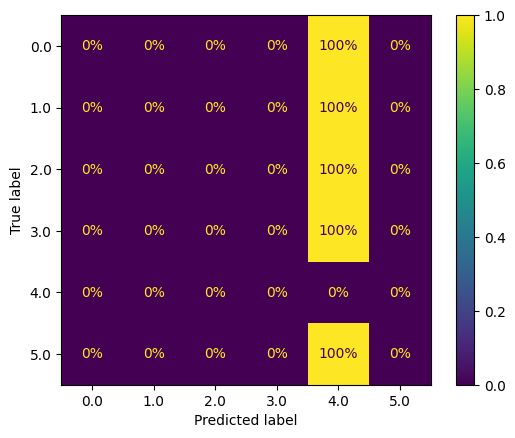

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
print('Test Set Performance', '\n')
print(classification_report(y_test_conv, y_pred_conv))
print(confusion_matrix(y_test_conv, y_pred_conv), '\n')
sample_weight = (y_pred_conv != y_test_conv)
ConfusionMatrixDisplay.from_predictions(y_test_conv, y_pred_conv,
                                        sample_weight = sample_weight,
                                        normalize = 'true',
                                        values_format = '.0%')